# Introduction

## Lab2: Train a Convolutional Neural Network (CNN).

In this Lab session we will learn how to train a CNN from scratch for classifying MNIST digits.

In [1]:
# import necessary libraries
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms as T
import torch.nn.functional as F
import matplotlib.pyplot as plt

### Define LeNet

![network architecture](https://www.researchgate.net/profile/Lucijano-Berus/publication/329891470/figure/fig1/AS:707347647307776@1545656229128/Architecture-of-LeNet-5-a-Convolutional-Neural-Network-for-digits-digits-recognition-An.ppm)

Here we are going to define our first CNN which is **LeNet** in this case. This architecture has been introduced and is detailed in [this article](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf). To construct a LeNet we will be using some convolutional layers followed by some fully-connected layers. The convolutional layers can be simply defined using `torch.nn.Conv2d` module of `torch.nn` package. Details can be found [here](https://pytorch.org/docs/stable/nn.html#conv2d). Moreover, we will use pooling operation to reduce the size of convolutional feature maps. For this case we are going to use `torch.nn.functional.max_pool2d`. Details about maxpooling can be found [here](https://pytorch.org/docs/stable/nn.html#max-pool2d)

Differently from our previous Lab, we will use a Rectified Linear Units (ReLU) as activation function with the help of `torch.nn.functional.relu`, replacing `torch.nn.Sigmoid`. Details about ReLU can be found [here](https://pytorch.org/docs/stable/nn.html#id26).

In [2]:
class LeNet(torch.nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()
    self.conv1 = nn.Conv2d(1, 6, 5)
    self.max_pool1 = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.max_pool2 = nn.MaxPool2d(2)
    self.fc1 = nn.Linear(5*5*16, 120)
    self.relu1 = nn.ReLU()
    self.fc2 = nn.Linear(120, 84)
    self.relu2 = nn.ReLU()
    self.fc3 = nn.Linear(84, 10)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    
    x = self.conv1(x)
    x = self.max_pool1(x)

    x = self.conv2(x)
    x = self.max_pool1(x)

    x = x.view(x.shape[0], -1) # Flatten

    x = self.fc1(x)
    x = self.relu1(x)

    x = self.fc2(x)
    x = self.relu2(x)

    x = self.fc3(x)
    x = self.softmax(x)
    
    return x

In [3]:
net = LeNet()
print(net)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


### Define cost function

In [4]:
def get_cost_function():
  cost_function = nn.BCELoss()
  return cost_function

### Define the optimizer

We will use SGD with learning rate-lr, weight_decay=wd and  momentum=momentum 

In [5]:
def get_optimizer(net, lr, wd, momentum):
  optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd, momentum=momentum)
  return optimizer

### Train and test functions

In [6]:
def test(net, data_loader, cost_function):
  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  net.eval() # Strictly needed if network contains layers which has different behaviours between train and test
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(data_loader):
      # Load data into GPU
      inputs = inputs.to(device).to(torch.float32)
      targets = targets.to(device)
        
      # Forward pass
      outputs = net(inputs)

      target_hot = F.one_hot(targets, num_classes=10).to(torch.float32)

      # Apply the loss
      loss = cost_function(outputs, target_hot)

      # Better print something
      samples+=inputs.shape[0]
      cumulative_loss += loss.item() # Note: the .item() is needed to extract scalars from tensors
      _, predicted = outputs.max(1)
      cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100


def train(net,data_loader,optimizer,cost_function):
  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  
  net.train() # Strictly needed if network contains layers which has different behaviours between train and test
  for batch_idx, (inputs, targets) in enumerate(data_loader):
    # Load data into GPU
    inputs = inputs.to(device).to(torch.float32)
    targets = targets.to(device)
      
    # Forward pass
    outputs = net(inputs)

    target_hot = F.one_hot(targets, num_classes=10).to(torch.float32)

    # Apply the loss
    loss = cost_function(outputs,target_hot)

    # Reset the optimizer
      
    # Backward pass
    loss.backward()
    
    # Update parameters
    optimizer.step()
    
    optimizer.zero_grad()

    # Better print something, no?
    samples+=inputs.shape[0]
    cumulative_loss += loss.item()
    _, predicted = outputs.max(1)
    cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100

### Define the function that fetches a data loader that is then used during iterative training.

We will learn a new thing in this function as how to Normalize the inputs given to the network.

***Why Normalization is needed***? 

To have nice and stable training of the network it is recommended to normalize the network inputs between \[-1, 1\]. 

***How it can be done***? 

This can be simply done using `torchvision.transforms.Normalize()` transform. Details can be found [here](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize).

In [7]:
def get_data(batch_size, test_batch_size=256):
  
  # Prepare data transformations and then combine them sequentially
  transform = list()
  transform.append(T.ToTensor())                            # converts Numpy to Pytorch Tensor
  transform.append(T.Normalize(mean=[0.5], std=[0.5]))      # Normalizes the Tensors between [-1, 1]
  transform.append(T.Pad(2))                                # Add zero-padding so that the images have a size 32*32
  transform = T.Compose(transform)                          # Composes the above transformations into one.

  # Load data
  full_training_data = torchvision.datasets.MNIST('./data', train=True, transform=transform, download=True) 
  test_data = torchvision.datasets.MNIST('./data', train=False, transform=transform, download=True) 
  

  # Create train and validation splits
  num_samples = len(full_training_data)
  training_samples = int(num_samples*0.5+1)
  validation_samples = num_samples - training_samples

  training_data, validation_data = torch.utils.data.random_split(full_training_data, [training_samples, validation_samples])

  # Initialize dataloaders
  train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(validation_data, test_batch_size, shuffle=False)
  test_loader = torch.utils.data.DataLoader(test_data, test_batch_size, shuffle=False)
  
  return train_loader, val_loader, test_loader

### Wrapping everything up

Finally, we need a main function which initializes everything + the needed hyperparameters and loops over multiple epochs (printing the results).

In [8]:
'''
Input arguments
  batch_size: Size of a mini-batch
  weight_decay: Weight decay co-efficient for regularization of weights
  momentum: Momentum for SGD optimizer
  epochs: Number of epochs for training the network
'''

def main(batch_size=128, 
         learning_rate=0.01, 
         weight_decay=0.000001, 
         momentum=0.9, 
         epochs=50):
  
  train_loader, val_loader, test_loader = get_data(batch_size)

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  
  # TODO for defining LeNet-5 
  
  optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)
  
  cost_function = get_cost_function()

  print('Before training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  for e in range(epochs):
    train_loss, train_accuracy = train(net, train_loader, optimizer, cost_function)
    val_loss, val_accuracy = test(net, val_loader, cost_function)
    print('Epoch: {:d}'.format(e+1))
    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    print('-----------------------------------------------------')

  print('After training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

Lets train!

In [9]:
main(epochs=20) # We do on only 20 epochs because it's too long

100%|██████████| 9912422/9912422 [00:00<00:00, 192472124.98it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 53742543.84it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 55961510.86it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4862309.54it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Before training:
	 Training loss 0.00255, Training accuracy 7.50
	 Validation loss 0.00128, Validation accuracy 7.65
	 Test loss 0.00130, Test accuracy 7.79
-----------------------------------------------------
Epoch: 1
	 Training loss 0.00254, Training accuracy 14.53
	 Validation loss 0.00126, Validation accuracy 27.73
-----------------------------------------------------
Epoch: 2
	 Training loss 0.00240, Training accuracy 37.72
	 Validation loss 0.00101, Validation accuracy 49.16
-----------------------------------------------------
Epoch: 3
	 Training loss 0.00097, Training accuracy 77.88
	 Validation loss 0.00026, Validation accuracy 88.47
-----------------------------------------------------
Epoch: 4
	 Training loss 0.00044, Training accuracy 90.05
	 Validation loss 0.00019, Validation accuracy 91.19
-----------------------------------------------------
Epoch: 5
	 Training loss 0.00033, Training accuracy 92

Using the proper metric from sklearn, check which character is most frequently confused with which: can you explain why ?



In [10]:
net.eval() # Set model to evaluation mode to avoid the computation of the gradients

train_loader, val_loader, test_loader = get_data(128) 

# Create an empty list to store the outputs
predictions = []
true_labels = []

# Iterate over the test loader
for batch_images, labels in test_loader:

    batch_outputs = net(batch_images)
    batch_pred = torch.argmax(batch_outputs, dim=1)
    predictions.append(batch_pred)
    true_labels.append(labels)

# Concatenate the outputs from all batches along the batch dimension
predictions = torch.cat(predictions, dim=0).numpy()
true_labels = torch.cat(true_labels, dim=0).numpy()

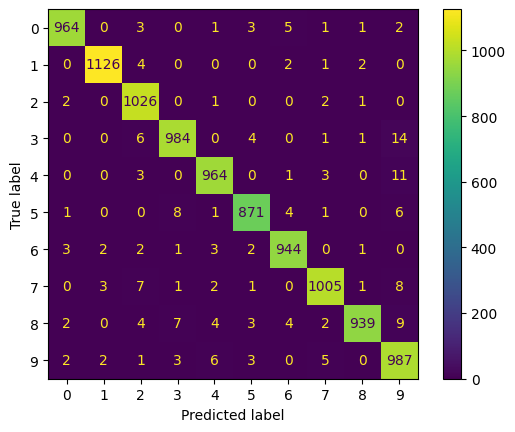

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

The biggest confusion is between 7 with the 2, the 3 with the 5 and 8, and the 4 with the 9. That could be explained by the fact that these 

The LeNet5 architecture can also be implemented using the sequential API ([see documentation ](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)). Reimplement it with this API.

In [ ]:
net_2 = nn.Sequential(
  nn.Conv2d(1, 6, 5),
  nn.MaxPool2d(2),
  nn.Conv2d(6, 16, 5),
  nn.MaxPool2d(2),
  nn.Flatten(),
  nn.Linear(5*5*16, 120),
  nn.ReLU(),
  nn.Linear(120, 84),
  nn.ReLU(),
  nn.Linear(84, 10),
  nn.Softmax(dim=1)
)
print(net_2)

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=400, out_features=120, bias=True)
  (6): ReLU()
  (7): Linear(in_features=120, out_features=84, bias=True)
  (8): ReLU()
  (9): Linear(in_features=84, out_features=10, bias=True)
  (10): Softmax(dim=1)
)


##Experiments


* Implement adaptive early stopping: if the validation loss did not decrease for K consecutive epochs, stop training.
* Change dataset in order to evaluate the LeNet5 network on cifar10 dataset. You can have a look at the pytorch documentation to easily access the cifar10 dataset. 
* Try to improve performance with:
   *   data-augmentation
   *   dropout
* Implement the resnet18 architecture using the Resnet18 class from pytorch.





In [13]:
'''
Input arguments
  batch_size: Size of a mini-batch
  weight_decay: Weight decay co-efficient for regularization of weights
  momentum: Momentum for SGD optimizer
  epochs: Number of epochs for training the network
'''

def main_es(batch_size=128, 
            learning_rate=0.01, 
            weight_decay=0.000001, 
            momentum=0.9, 
            epochs=50,
            K=2):
  
  train_loader, val_loader, test_loader = get_data(batch_size)

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  
  # TODO for defining LeNet-5 
  
  optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)
  
  cost_function = get_cost_function()

  print('Before training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  previous_loss = 1000
  n_wout_imp = 0

  for e in range(epochs):
    train_loss, train_accuracy = train(net, train_loader, optimizer, cost_function)
    val_loss, val_accuracy = test(net, val_loader, cost_function)
    print('Epoch: {:d}'.format(e+1))
    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    print('-----------------------------------------------------')
    if val_loss < previous_loss:
      n_wout_imp = 0
    else:
      n_wout_imp += 1
    if n_wout_imp == K-1:
      break
      
    previous_loss = val_loss

  print('After training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

We perform this on the same NN that before because it's already trained and so it needs less epochs to stabilize.

In [14]:
main_es()

Before training:
	 Training loss 0.00009, Training accuracy 98.10
	 Validation loss 0.00004, Validation accuracy 98.23
	 Test loss 0.00004, Test accuracy 98.10
-----------------------------------------------------
Epoch: 1
	 Training loss 0.00008, Training accuracy 98.12
	 Validation loss 0.00004, Validation accuracy 98.22
-----------------------------------------------------
Epoch: 2
	 Training loss 0.00007, Training accuracy 98.35
	 Validation loss 0.00004, Validation accuracy 98.51
-----------------------------------------------------
Epoch: 3
	 Training loss 0.00007, Training accuracy 98.42
	 Validation loss 0.00004, Validation accuracy 98.45
-----------------------------------------------------
After training:
	 Training loss 0.00006, Training accuracy 98.70
	 Validation loss 0.00004, Validation accuracy 98.45
	 Test loss 0.00004, Test accuracy 98.29
-----------------------------------------------------


# Test LeNet with CIFAR10

## Load the dataset

In [15]:
 # Prepare data transformations and then combine them sequentially
transform = list()
transform.append(T.ToTensor())                            # converts Numpy to Pytorch Tensor
transform.append(T.Lambda(lambda x: torch.mean(x, dim=0).view(1, 32, 32)))       # Put the RGB image in grayscale
transform.append(T.Normalize(mean=[0.5], std=[0.5]))      # Normalizes the Tensors between [-1, 1]
transform = T.Compose(transform)                          # Composes the above transformations into one.

# Load data
full_training_data = torchvision.datasets.CIFAR10('./data', train=True, transform=transform, download=True) 
test_data = torchvision.datasets.CIFAR10('./data', train=False, transform=transform, download=True) 


# Create train and validation splits
num_samples = len(full_training_data)
training_samples = int(num_samples*0.5+1)
validation_samples = num_samples - training_samples

training_data, validation_data = torch.utils.data.random_split(full_training_data, [training_samples, validation_samples])

batch_size = 128
test_batch_size = 256

# Initialize dataloaders
train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(validation_data, test_batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, test_batch_size, shuffle=False)

100%|██████████| 170498071/170498071 [00:05<00:00, 28951294.42it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


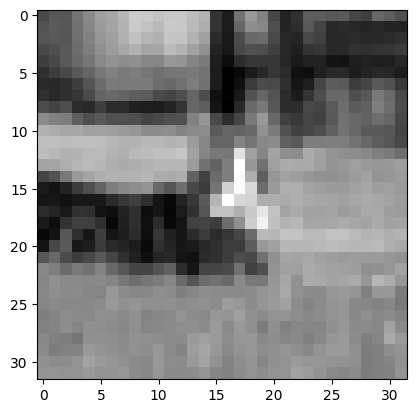

In [16]:
# We visualize an image
for batch_img, label in train_loader:
  plt.imshow(batch_img[5][0], cmap='gray')
  plt.show()
  break

## Test with LeNet

We could first evaluate the results with the current weights, normally we will get bad results because the layers for classification are not trained for the same thing. We could chose to train only the classification layers by freezing the others layers (we use the features extraction of the NN trained with MNIST), or just train everything (that is a better option but much time costly). We do the second thing.

In [17]:
learning_rate=0.01
weight_decay=0.000001
momentum=0.9
epochs=50
K=2
  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# TODO for defining LeNet-5 

optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)

cost_function = get_cost_function()

print('Before training:')
train_loss, train_accuracy = test(net, train_loader, cost_function)
val_loss, val_accuracy = test(net, val_loader, cost_function)
test_loss, test_accuracy = test(net, test_loader, cost_function)

print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
print('-----------------------------------------------------')

previous_loss = 1000
n_wout_imp = 0

for e in range(epochs):
  train_loss, train_accuracy = train(net, train_loader, optimizer, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  print('Epoch: {:d}'.format(e+1))
  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('-----------------------------------------------------')
  if val_loss < previous_loss:
    n_wout_imp = 0
  else:
    n_wout_imp += 1
  if n_wout_imp == K-1:
    break
    
  previous_loss = val_loss

print('After training:')
train_loss, train_accuracy = test(net, train_loader, cost_function)
val_loss, val_accuracy = test(net, val_loader, cost_function)
test_loss, test_accuracy = test(net, test_loader, cost_function)

print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
print('-----------------------------------------------------')

Before training:
	 Training loss 0.00524, Training accuracy 8.69
	 Validation loss 0.00261, Validation accuracy 8.68
	 Test loss 0.00267, Test accuracy 8.91
-----------------------------------------------------
Epoch: 1
	 Training loss 0.00259, Training accuracy 19.03
	 Validation loss 0.00118, Validation accuracy 25.93
-----------------------------------------------------
Epoch: 2
	 Training loss 0.00229, Training accuracy 28.75
	 Validation loss 0.00111, Validation accuracy 31.73
-----------------------------------------------------
Epoch: 3
	 Training loss 0.00216, Training accuracy 34.04
	 Validation loss 0.00105, Validation accuracy 35.73
-----------------------------------------------------
Epoch: 4
	 Training loss 0.00205, Training accuracy 37.92
	 Validation loss 0.00101, Validation accuracy 38.77
-----------------------------------------------------
Epoch: 5
	 Training loss 0.00198, Training accuracy 40.47
	 Validation loss 0.00098, Validation accuracy 40.69
------------------

## Data augmentation and Dropout

We decide to put dropout on fc1 and fc2.

In [18]:
net.fc1 = nn.Sequential(
    nn.Linear(400, 120),
    nn.Dropout(p=0.5)
)                         

net.fc2 = nn.Sequential(
    nn.Linear(120, 84),
    nn.Dropout(p=0.5)
)     

print(net)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): Dropout(p=0.5, inplace=False)
  )
  (relu1): ReLU()
  (fc2): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): Dropout(p=0.5, inplace=False)
  )
  (relu2): ReLU()
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


In [28]:
 # Prepare data transformations and then combine them sequentially
transform = list()
transform.append(T.ToTensor())                            # converts Numpy to Pytorch Tensor
transform.append(T.Lambda(lambda x: torch.mean(x, dim=0).view(1, 32, 32)))       # Put the RGB image in grayscale
transform.append(T.Normalize(mean=[0.5], std=[0.5]))      # Normalizes the Tensors between [-1, 1]
transform = T.Compose(transform)                          # Composes the above transformations into one.

transform_data_augm = list()
transform_data_augm.append(T.ToTensor())                            # converts Numpy to Pytorch Tensor
transform_data_augm.append(T.Lambda(lambda x: torch.mean(x, dim=0).view(1, 32, 32)))       # Put the RGB image in grayscale
transform_data_augm.append(T.RandomRotation(10))  # Rotation aléatoire dans une plage de -10 à +10 degrés
transform_data_augm.append(T.RandomHorizontalFlip())
transform_data_augm.append(T.Normalize(mean=[0.5], std=[0.5]))      # Normalizes the Tensors between [-1, 1]
transform_data_augm = T.Compose(transform_data_augm)                          # Composes the above transformations into one.

# Load data
full_training_data = torchvision.datasets.CIFAR10('./data', train=True, transform=transform_data_augm, download=True) 
test_data = torchvision.datasets.CIFAR10('./data', train=False, transform=transform, download=True) 


# Create train and validation splits
num_samples = len(full_training_data)
training_samples = int(num_samples*0.5+1)
validation_samples = num_samples - training_samples

training_data, validation_data = torch.utils.data.random_split(full_training_data, [training_samples, validation_samples])

batch_size = 128
test_batch_size = 256

# Initialize dataloaders
train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(validation_data, test_batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, test_batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


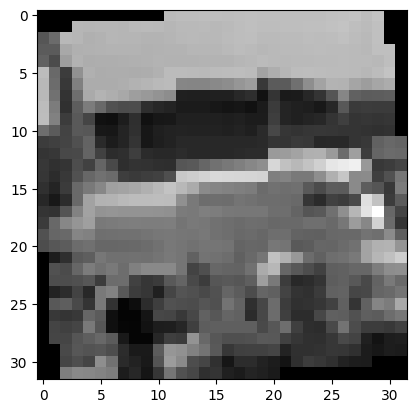

In [29]:
for batch_img, label in train_loader:
  plt.imshow(batch_img[5][0], cmap='gray')
  plt.show()
  break

In [30]:
learning_rate=0.01
weight_decay=0.000001
momentum=0.9
epochs=50
K=2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# TODO for defining LeNet-5 

optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)

cost_function = get_cost_function()

print('Before training:')
train_loss, train_accuracy = test(net, train_loader, cost_function)
val_loss, val_accuracy = test(net, val_loader, cost_function)
test_loss, test_accuracy = test(net, test_loader, cost_function)

print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
print('-----------------------------------------------------')

previous_loss = 1000
n_wout_imp = 0

for e in range(epochs):
  train_loss, train_accuracy = train(net, train_loader, optimizer, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  print('Epoch: {:d}'.format(e+1))
  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('-----------------------------------------------------')
  if val_loss < previous_loss:
    n_wout_imp = 0
  else:
    n_wout_imp += 1
  if n_wout_imp == K-1:
    break
    
  previous_loss = val_loss

print('After training:')
train_loss, train_accuracy = test(net, train_loader, cost_function)
val_loss, val_accuracy = test(net, val_loader, cost_function)
test_loss, test_accuracy = test(net, test_loader, cost_function)

print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
print('-----------------------------------------------------')

Before training:
	 Training loss 0.00271, Training accuracy 9.58
	 Validation loss 0.00135, Validation accuracy 9.75
	 Test loss 0.00138, Test accuracy 9.73
-----------------------------------------------------
Epoch: 1
	 Training loss 0.00252, Training accuracy 16.52
	 Validation loss 0.00117, Validation accuracy 29.27
-----------------------------------------------------
Epoch: 2
	 Training loss 0.00236, Training accuracy 23.20
	 Validation loss 0.00112, Validation accuracy 32.64
-----------------------------------------------------
Epoch: 3
	 Training loss 0.00229, Training accuracy 26.48
	 Validation loss 0.00108, Validation accuracy 35.19
-----------------------------------------------------
Epoch: 4
	 Training loss 0.00224, Training accuracy 28.49
	 Validation loss 0.00105, Validation accuracy 36.46
-----------------------------------------------------
Epoch: 5
	 Training loss 0.00219, Training accuracy 30.41
	 Validation loss 0.00103, Validation accuracy 38.14
------------------

## Testing with Resnet

In [33]:
resnet = torchvision.models.resnet18()
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

We have to change the classification layer. 

In [38]:
resnet.fc = nn.Sequential(
    nn.Linear(512, 10),
    nn.Softmax(dim=1)
)

print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Now we freeze all the layers except the classification one.

In [45]:
for param in resnet.parameters():
  param.requires_grad = False

for param in resnet.fc.parameters():
    param.requires_grad = True

In [35]:
 # Prepare data transformations and then combine them sequentially
transform = list()
transform.append(T.ToTensor())                            # converts Numpy to Pytorch Tensor
transform.append(T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]))      # Normalizes the Tensors between [-1, 1]
transform = T.Compose(transform)                          # Composes the above transformations into one.

# Load data
full_training_data = torchvision.datasets.CIFAR10('./data', train=True, transform=transform, download=True) 
test_data = torchvision.datasets.CIFAR10('./data', train=False, transform=transform, download=True) 


# Create train and validation splits
num_samples = len(full_training_data)
training_samples = int(num_samples*0.5+1)
validation_samples = num_samples - training_samples

training_data, validation_data = torch.utils.data.random_split(full_training_data, [training_samples, validation_samples])

batch_size = 128
test_batch_size = 256

# Initialize dataloaders
train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(validation_data, test_batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, test_batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


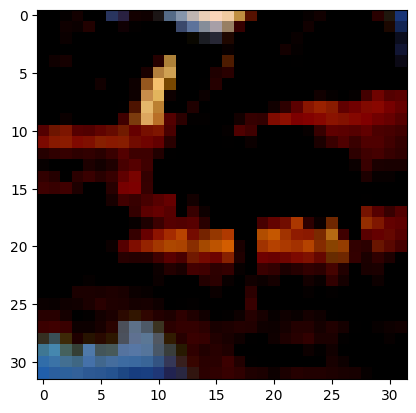

In [36]:
for batch_img, label in train_loader:
  img = batch_img[5].permute(1, 2, 0).detach().numpy()
  plt.imshow(img)
  plt.show()
  break

In [46]:
learning_rate=0.01
weight_decay=0.000001
momentum=0.9
epochs=5 #because it's really long
K=2
  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# TODO for defining LeNet-5 

optimizer = get_optimizer(resnet, learning_rate, weight_decay, momentum)

cost_function = get_cost_function()

print('Before training:')
train_loss, train_accuracy = test(resnet, train_loader, cost_function)
val_loss, val_accuracy = test(resnet, val_loader, cost_function)
test_loss, test_accuracy = test(resnet, test_loader, cost_function)

print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
print('-----------------------------------------------------')

previous_loss = 1000
n_wout_imp = 0

for e in range(epochs):
  train_loss, train_accuracy = train(resnet, train_loader, optimizer, cost_function)
  val_loss, val_accuracy = test(resnet, val_loader, cost_function)
  print('Epoch: {:d}'.format(e+1))
  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('-----------------------------------------------------')
  if val_loss < previous_loss:
    n_wout_imp = 0
  else:
    n_wout_imp += 1
  if n_wout_imp == K-1:
    break
    
  previous_loss = val_loss

print('After training:')
train_loss, train_accuracy = test(resnet, train_loader, cost_function)
val_loss, val_accuracy = test(resnet, val_loader, cost_function)
test_loss, test_accuracy = test(resnet, test_loader, cost_function)

print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
print('-----------------------------------------------------')

Before training:
	 Training loss 0.00100, Training accuracy 73.57
	 Validation loss 0.00085, Validation accuracy 52.42
	 Test loss 0.00088, Test accuracy 52.76
-----------------------------------------------------
Epoch: 1
	 Training loss 0.00097, Training accuracy 74.89
	 Validation loss 0.00084, Validation accuracy 53.99
-----------------------------------------------------


KeyboardInterrupt: ignored

I didn't train because i didn't have the patience but on the first epochs that works far better. But everything works, I let you persuade it :).